# 0. Imports

In [2]:
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Classificadores
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Avaliadores
from sklearn.metrics import classification_report, confusion_matrix
from utils import plot_confusion_matrix, evaluate_classifiers
from sklearn.model_selection import KFold, cross_val_score

# Train Test Split
from sklearn.model_selection import train_test_split

# tqdm
from tqdm import tqdm

ModuleNotFoundError: No module named 'utils'

## 0.1 - Funções

In [4]:
def merge_csv(*csv_files, normalize_data=True):
    path = f'./data/novos_DataFrames/'
    dataframes = [pd.read_csv(path+file) for file in csv_files]
    resultado = pd.concat(dataframes, axis=1)
    
    if normalize_data:
        # Normalização dos dados usando Z-score
        resultado_normalizado = resultado.apply(zscore)
        return resultado_normalizado
    
    return resultado.values
    #return resultado_normalizado.values

# 1. Classificando usando diferentes métodos e combinações de DataFrames

## 1.1 - Recuperando as labels

In [5]:
df = pd.read_csv('./data/pgm-dataset-v6-clean.csv')
y = df['novoSetorDestino'].to_numpy()

class_names = ['A.F.', 'D.C.C.', 'Out.', 'P.A.', 'P.F.']

FileNotFoundError: [Errno 2] No such file or directory: './data/pgm-dataset-v6-clean.csv'

In [4]:
np.unique(y)

array(['APOIO FISCAL', 'DEPARTAMENTO DE CÁLCULOS E CONTABILIDADE',
       'Outras', 'Procuradoria Administrativa', 'Procuradoria Fiscal '],
      dtype=object)

## 1.2 - Definindo os Classificadores

In [5]:
classificadores = [('Naive Bayes', GaussianNB()), ('Random Forest', RandomForestClassifier()), ('SVM', SVC())]

# 1.2 - TFIDF

In [5]:
matriz_agg = merge_csv('df_tfidf.csv', normalize_data=False)

X_train, X_test, y_train, y_test = train_test_split(matriz_agg, y, test_size=0.30, random_state=42)

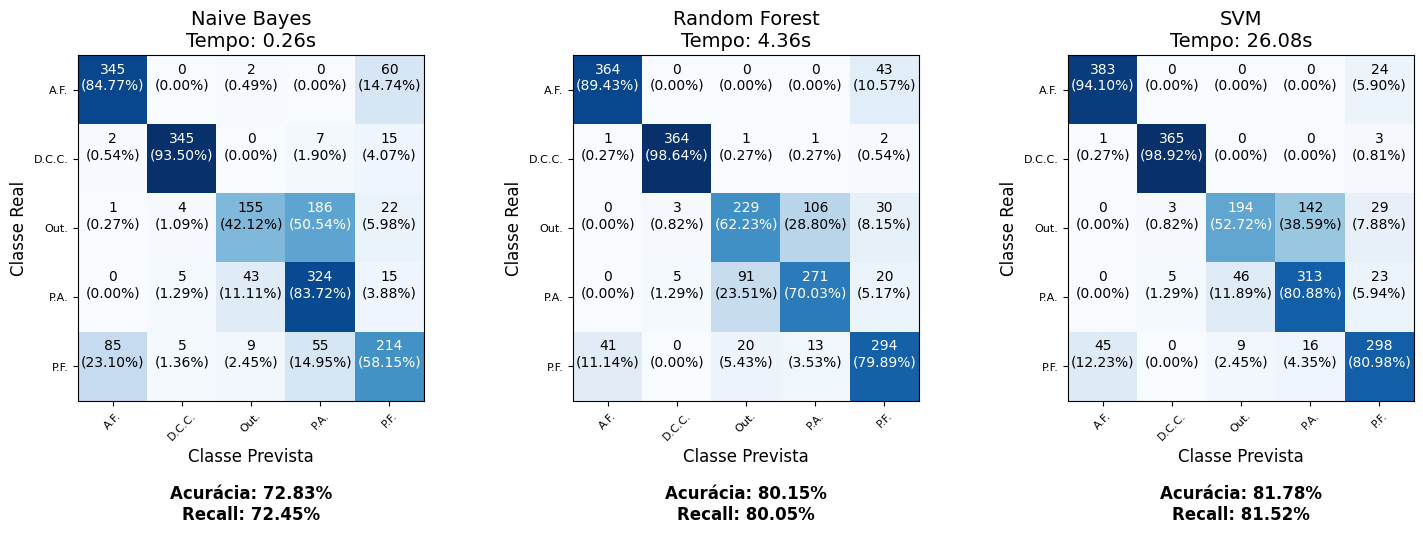

In [6]:
evaluate_classifiers(classificadores, X_train, y_train, X_test, y_test, class_names)

# 1.3 - Assuntos + Classe Processo + Orgão Julgador

In [7]:
matriz_agg = merge_csv('df_assuntos.csv', 'df_classeProcesso.csv', 'df_orgaoJulgador.csv', normalize_data=False)

X_train, X_test, y_train, y_test = train_test_split(matriz_agg, y, test_size=0.30, random_state=42)

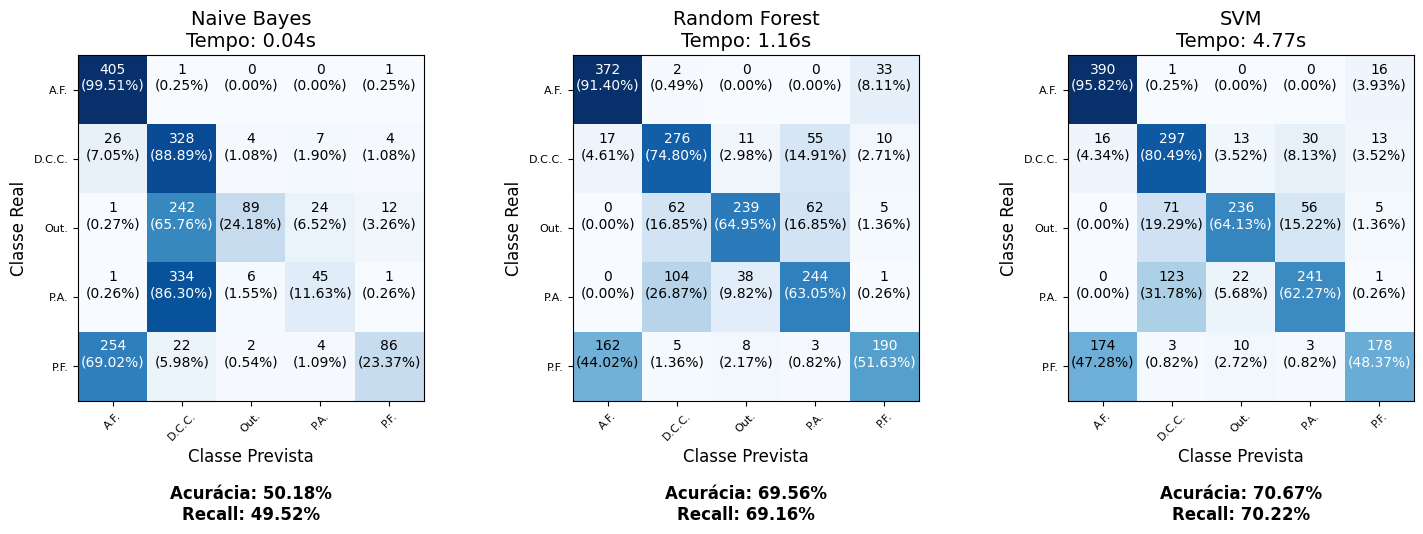

In [8]:
evaluate_classifiers(classificadores, X_train, y_train, X_test, y_test, class_names)

# 1.4 - Assuntos + Classe Processo + Orgão Julgador + Anexos

In [9]:
matriz_agg = merge_csv('df_assuntos.csv', 'df_classeProcesso.csv', 'df_orgaoJulgador.csv', 'df_anexos.csv', normalize_data=False)

X_train, X_test, y_train, y_test = train_test_split(matriz_agg, y, test_size=0.30, random_state=42)

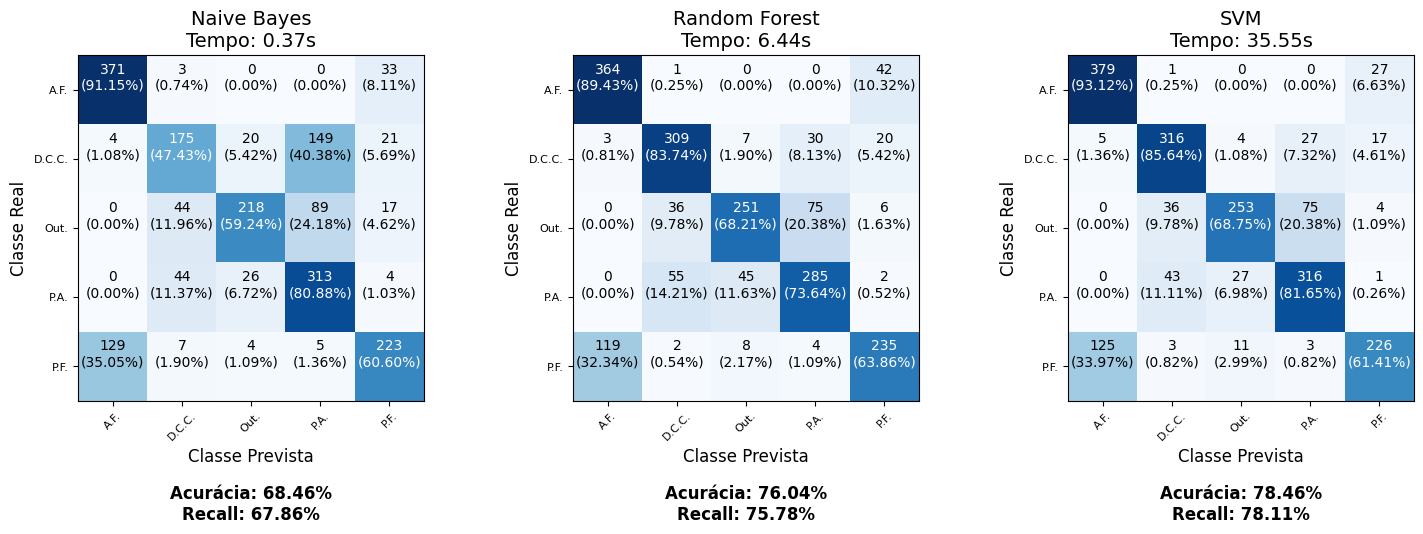

In [10]:
evaluate_classifiers(classificadores, X_train, y_train, X_test, y_test, class_names)

# 1.5 - TFIDF + Assuntos

In [6]:
matriz_agg = merge_csv('df_tfidf.csv', 'df_assuntos.csv', normalize_data=False)

X_train, X_test, y_train, y_test = train_test_split(matriz_agg, y, test_size=0.30, random_state=42)

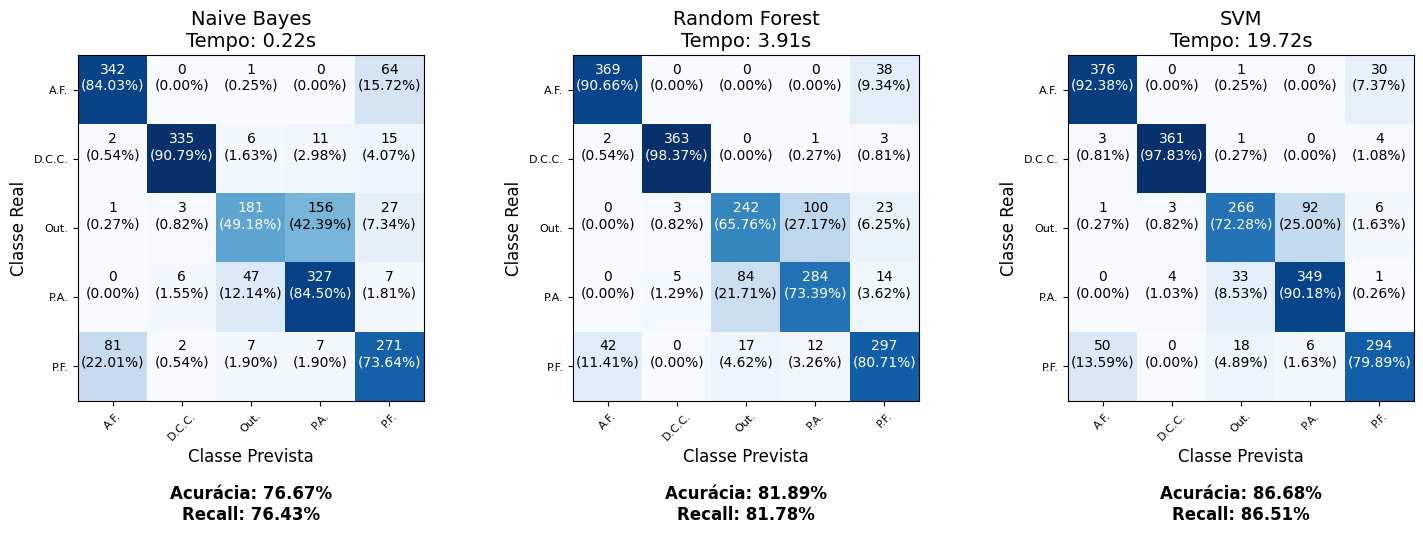

In [7]:
evaluate_classifiers(classificadores, X_train, y_train, X_test, y_test, class_names)

### 1.5.1 - Validando SVM do TFIDF + Assuntos com Cross Validation

In [31]:
class SVMCrossValidation():
    def __init__(self, n_folds):
        self.clf = SGDClassifier()
        self.n_folds = n_folds

    def fit(self, X_train, y_train):
        self.clf.fit(X_train, y_train)
    
    def predict(self, X_test):
        self.clf.predict(X_test)

    def cross_validation(self, X, y):
        cv = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        self.matrices = []

        for i, (train_index, test_index) in tqdm(enumerate(cv.split(X, y))):
            # Separando dados de treinamento e teste para o Fold
            X_train = X[train_index]; X_test = X[test_index]
            y_train = y[train_index]; y_test = y[test_index]

            # Treinando o Fold
            self.clf.fit(X_train, y_train)

            # Predição
            y_pred = self.clf.predict(X_test)

            # Recuperando a matriz de confusão
            cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            self.matrices.append(cm)

        self.matrices = np.stack(self.matrices)
    
    def plot_confusion_matrix(self):
        # Calcula a média e desvio padrão
        mean_matrix = np.mean(self.matrices, axis=0)
        std_matrix = np.std(self.matrices, axis=0)

        # Calcula a acurácia média e recall médios total
        accuracy = np.trace(mean_matrix) / np.sum(mean_matrix)
        recall = np.mean(np.diag(mean_matrix) / np.sum(mean_matrix, axis=1))

        # Cria o gráfico
        plt.figure(figsize=(10, 8))
        plt.imshow(mean_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f'Matriz de Confusão - {self.n_folds} Folds', fontsize=16)

        # Adiciona rótulos
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45, fontsize=6)
        plt.yticks(tick_marks, class_names, fontsize=8)

        # Adiciona os valores na matriz
        thresh = mean_matrix.max() / 2.
        for i, j in np.ndindex(mean_matrix.shape):
            plt.text(j, i, f'Recall Médio: {mean_matrix[i, j]*100:.2f}%\nDP Médio: {std_matrix[i, j]*100:.2f}%',
                     horizontalalignment="center",
                     color="white" if mean_matrix[i, j] > thresh else "black",
                     fontsize=8)
        
        plt.figtext(0.5, -0.1, f'Acurácia: {accuracy*100:.2f}%\nRecall: {recall*100:.2f}%',
                ha='center', fontsize=12, color='black', fontweight='bold')
        
        plt.ylabel('Classe Real', fontsize=14)
        plt.xlabel('Classe Prevista', fontsize=14)
        plt.tight_layout()
        plt.show()


        

In [32]:
cross_val_inst = SVMCrossValidation(n_folds=10)

cross_val_inst.cross_validation(matriz_agg, y)

10it [00:31,  3.14s/it]


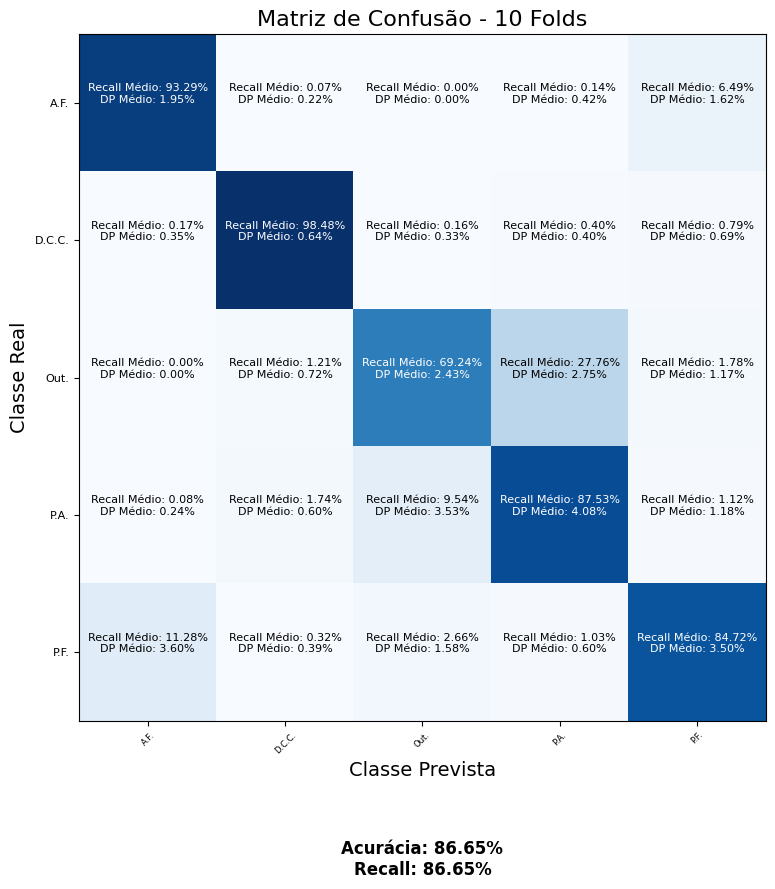

In [33]:
cross_val_inst.plot_confusion_matrix()

In [3]:
l_svc = LinearSVC()

l_svc.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [50]:
l_svc.decision_function(X_test).argmax(axis=1)[:10]

array([0, 3, 2, 3, 4, 2, 2, 4, 2, 3])

In [51]:
l_svc.predict(X_test)[:10]

array(['APOIO FISCAL', 'Procuradoria Administrativa', 'Outras',
       'Procuradoria Administrativa', 'Procuradoria Fiscal ', 'Outras',
       'Outras', 'Procuradoria Fiscal ', 'Outras',
       'Procuradoria Administrativa'], dtype=object)

In [65]:
l_svc.decision_function(X_test)[:10]

array([[ 0.52886001, -1.37574695, -2.33891678, -1.70977737, -0.409322  ],
       [-1.83701144, -1.25650755, -0.75478683,  0.67888638, -1.04045896],
       [-1.70709173, -1.49976427,  1.32632702, -1.6290089 , -1.13236361],
       [-1.04427141, -1.27927573, -0.08032618,  0.16538684, -1.96874518],
       [-0.63387033, -1.48092813, -0.45069843, -1.13258286,  0.50694823],
       [-1.59044175, -1.06744725,  0.28947863, -0.25090934, -1.74350354],
       [-2.08323343, -1.47558001,  0.52359974, -0.22474479, -0.74308159],
       [-0.90960832, -1.38267408, -1.4987191 , -2.71323407,  0.83093463],
       [-2.05172414, -1.27211824,  0.93875148, -1.45290347, -0.56227587],
       [-1.27781617, -1.1590953 , -0.94428582,  0.81806337, -1.80419402]])

In [69]:
np.sum(np.exp(l_svc.decision_function(X_test)[:10]), axis=1)

array([2.89108591, 3.2390233 , 4.69015099, 2.87248359, 3.37756081,
       2.83645114, 3.31563236, 3.23878989, 3.7693385 , 3.41208638])

### Separando textos para o professor

In [37]:
matriz_agg.shape

(6327, 3987)

In [24]:
from scipy.spatial.distance import cdist

def instancias_mais_proximas(matriz, classes, N):
    matriz = np.array(matriz)
    classes = np.array(classes)
    
    indices_resultado = []
    
    for classe in np.unique(classes):
        indices_classe = np.where(classes == classe)[0]
        sub_matriz = matriz[indices_classe]
        
        centro_gravidade = np.mean(sub_matriz, axis=0)
        distancias = cdist(sub_matriz, [centro_gravidade], metric='euclidean').flatten()
        
        indices_ordenados = indices_classe[np.argsort(distancias)[:N]]
        indices_resultado.extend(indices_ordenados)
    
    return indices_resultado


In [28]:
index_mais_proximos = instancias_mais_proximas(matriz_agg, y, 300)

In [30]:
len(index_mais_proximos)

1500

In [36]:
df_selecionado = df.iloc[index_mais_proximos]
df_selecionado.to_csv('./data/novos_DataFrames/df_selecionado.csv', index=False)

### 1.5.2 - Validando RNA do TFIDF + Assuntos com Cross Validation

#### Fazendo uma classificação usando MLPClassifier (Remover)

In [20]:
model = MLPClassifier(hidden_layer_sizes=(512, 64))

model.fit(X_train, y_train)


MLPClassifier(hidden_layer_sizes=(512, 64))

In [21]:
y_pred = model.predict(X_test)

In [22]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cm_normalized

array([[0.87960688, 0.002457  , 0.002457  , 0.002457  , 0.11302211],
       [0.00542005, 0.96747967, 0.00813008, 0.00542005, 0.01355014],
       [0.        , 0.01358696, 0.73913043, 0.2201087 , 0.02717391],
       [0.        , 0.02583979, 0.2118863 , 0.74677003, 0.01550388],
       [0.14130435, 0.00543478, 0.02173913, 0.01086957, 0.82065217]])

In [45]:
class MLPCrossValidation():
    def __init__(self, n_folds, hidden_layer=(512,)):
        self.clf = MLPClassifier(hidden_layer_sizes=hidden_layer, random_state=42)
        self.n_folds = n_folds

    def fit(self, X_train, y_train):
        self.clf.fit(X_train, y_train)
    
    def predict(self, X_test):
        self.clf.predict(X_test)

    def cross_validation(self, X, y):
        cv = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        self.matrices = []

        for i, (train_index, test_index) in tqdm(enumerate(cv.split(X, y))):
            # Separando dados de treinamento e teste para o Fold
            X_train = X[train_index]; X_test = X[test_index]
            y_train = y[train_index]; y_test = y[test_index]

            # Treinando o Fold
            self.clf.fit(X_train, y_train)

            # Predição
            y_pred = self.clf.predict(X_test)

            # Recuperando a matriz de confusão
            cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            self.matrices.append(cm)

        self.matrices = np.stack(self.matrices)
    
    def plot_confusion_matrix(self):
        # Calcula a média e desvio padrão
        mean_matrix = np.mean(self.matrices, axis=0)
        std_matrix = np.std(self.matrices, axis=0)

        # Calcula a acurácia média e recall médios total
        accuracy = np.trace(mean_matrix) / np.sum(mean_matrix)
        recall = np.mean(np.diag(mean_matrix) / np.sum(mean_matrix, axis=1))

        # Cria o gráfico
        plt.figure(figsize=(10, 8))
        plt.imshow(mean_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f'Matriz de Confusão - {self.n_folds} Folds', fontsize=16)

        # Adiciona rótulos
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45, fontsize=6)
        plt.yticks(tick_marks, class_names, fontsize=8)

        # Adiciona os valores na matriz
        thresh = mean_matrix.max() / 2.
        for i, j in np.ndindex(mean_matrix.shape):
            plt.text(j, i, f'Recall Médio: {mean_matrix[i, j]*100:.2f}%\nDP Médio: {std_matrix[i, j]*100:.2f}%',
                     horizontalalignment="center",
                     color="white" if mean_matrix[i, j] > thresh else "black",
                     fontsize=8)
        
        plt.figtext(0.5, -0.1, f'Acurácia: {accuracy*100:.2f}%\nRecall: {recall*100:.2f}%',
                ha='center', fontsize=12, color='black', fontweight='bold')
        
        plt.ylabel('Classe Real', fontsize=14)
        plt.xlabel('Classe Prevista', fontsize=14)
        plt.tight_layout()
        plt.show()


        

In [ ]:
cross_val_mlp = MLPCrossValidation(n_folds=10)

cross_val_mlp.cross_validation(matriz_agg, y)

0it [00:00, ?it/s]/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
1it [01:09, 69.60s/it]

In [14]:
class RNACrossValidation():
    def __init__(self, n_folds=5, hidden_layers=[32, 16], dropout_rates=[0.2, 0.2], learning_rate=0.001, epocas=50, batch_size=32):
        """
        Inicializa os parâmetros da RNA.
        
        Parâmetros:
        - n_folds: número de folds para cross-validation.
        - hidden_layers: lista com os tamanhos das camadas ocultas.
        - dropout_rates: lista com as taxas de dropout (deve ter mesmo tamanho que hidden_layers).
        - learning_rate: taxa de aprendizado do otimizador.
        - epocas: número de épocas de treinamento.
        - batch_size: tamanho do batch para treinamento.
        """
        self.n_folds = n_folds
        self.hidden_layers = hidden_layers
        self.dropout_rates = dropout_rates
        self.learning_rate = learning_rate
        self.epocas = epocas
        self.batch_size = batch_size
        #self.scaler = StandardScaler()

    def _criar_rede_neural(self, input_dim, output_dim):
        """Cria a arquitetura da rede neural dinamicamente."""
        layers = []
        in_dim = input_dim
        
        for hidden, dropout in zip(self.hidden_layers, self.dropout_rates):
            layers.append(nn.Linear(in_dim, hidden))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = hidden
        
        layers.append(nn.Linear(in_dim, output_dim))  # Camada de saída
        layers.append(nn.Softmax(dim=1))  # Softmax para classificação
        
        return nn.Sequential(*layers)

    def fit(self, X_train, y_train):
        """Treina a RNA com os dados de treinamento."""
        #X_train = self.scaler.fit_transform(X_train)
        input_dim = X_train.shape[1]
        output_dim = len(np.unique(y_train))

        self.modelo = self._criar_rede_neural(input_dim, output_dim)
        criterio = nn.CrossEntropyLoss()
        otimizador = optim.Adam(self.modelo.parameters(), lr=self.learning_rate)
        
        X_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_tensor = torch.tensor(y_train, dtype=torch.long)
        
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        self.modelo.train()
        for epoca in range(self.epocas):
            perda_total = 0
            for X_batch, y_batch in dataloader:
                otimizador.zero_grad()
                saida = self.modelo(X_batch)
                perda = criterio(saida, y_batch)
                perda.backward()
                otimizador.step()
                perda_total += perda.item()
            
            print(f"Época {epoca+1}/{self.epocas}, Perda: {perda_total:.4f}")

    def predict(self, X_test):
        """Faz previsões usando a RNA treinada."""
        #X_test = self.scaler.transform(X_test)
        X_tensor = torch.tensor(X_test, dtype=torch.float32)
        
        self.modelo.eval()
        with torch.no_grad():
            saida = self.modelo(X_tensor)
        
        return torch.argmax(saida, axis=1).numpy()

    def cross_validation(self, X, y):
        """Executa validação cruzada com KFold."""
        #X = self.scaler.fit_transform(X)
        cv = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        self.matrices = []

        for fold, (train_index, test_index) in tqdm(enumerate(cv.split(X, y)), total=self.n_folds, desc="Cross Validation Folds"):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Criar modelo para este fold
            input_dim = X_train.shape[1]
            output_dim = len(np.unique(y))
            self.modelo = self._criar_rede_neural(input_dim, output_dim)
            
            # Treinar o modelo
            self.fit(X_train, y_train)

            # Fazer predições
            y_pred = self.predict(X_test)

            # Calcular matriz de confusão normalizada
            cm = confusion_matrix(y_test, y_pred).astype('float')
            cm = cm / cm.sum(axis=1)[:, np.newaxis]
            self.matrices.append(cm)

        self.matrices = np.stack(self.matrices)

    def plot_confusion_matrix(self, class_names):
        """Plota a matriz de confusão média dos folds."""
        mean_matrix = np.mean(self.matrices, axis=0)
        std_matrix = np.std(self.matrices, axis=0)

        accuracy = np.trace(mean_matrix) / np.sum(mean_matrix)
        recall = np.mean(np.diag(mean_matrix) / np.sum(mean_matrix, axis=1))

        plt.figure(figsize=(10, 8))
        plt.imshow(mean_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f'Matriz de Confusão - {self.n_folds} Folds', fontsize=16)

        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45, fontsize=10)
        plt.yticks(tick_marks, class_names, fontsize=10)

        thresh = mean_matrix.max() / 2.
        for i, j in np.ndindex(mean_matrix.shape):
            plt.text(j, i, f'{mean_matrix[i, j]*100:.2f}%\n({std_matrix[i, j]*100:.2f}%)',
                     horizontalalignment="center",
                     color="white" if mean_matrix[i, j] > thresh else "black",
                     fontsize=8)

        plt.figtext(0.5, -0.1, f'Acurácia: {accuracy*100:.2f}%\nRecall: {recall*100:.2f}%',
                    ha='center', fontsize=12, color='black', fontweight='bold')

        plt.ylabel('Classe Real', fontsize=14)
        plt.xlabel('Classe Prevista', fontsize=14)
        plt.tight_layout()
        plt.show()


In [15]:
label_enc = LabelEncoder()
y_numerical = label_enc.fit_transform(y)

In [18]:
# Criando e rodando a validação cruzada
modelo = RNACrossValidation(n_folds=10, hidden_layers=[256, 128, 64], dropout_rates=[0.2, 0.2, 0.2], epocas=30, learning_rate=0.001)
modelo.cross_validation(matriz_agg, y_numerical)

Cross Validation Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Época 1/30, Perda: 218.0964
Época 2/30, Perda: 184.3555
Época 3/30, Perda: 180.5504
Época 4/30, Perda: 178.8808
Época 5/30, Perda: 177.6410
Época 6/30, Perda: 177.4897
Época 7/30, Perda: 176.6016
Época 8/30, Perda: 176.5058
Época 9/30, Perda: 175.8591
Época 10/30, Perda: 175.3452
Época 11/30, Perda: 175.3543
Época 12/30, Perda: 175.6751
Época 13/30, Perda: 175.4344
Época 14/30, Perda: 175.5392
Época 15/30, Perda: 175.0156
Época 16/30, Perda: 175.1756
Época 17/30, Perda: 174.2824
Época 18/30, Perda: 174.4024
Época 19/30, Perda: 174.6288
Época 20/30, Perda: 174.2850
Época 21/30, Perda: 174.1301
Época 22/30, Perda: 174.0197
Época 23/30, Perda: 174.1830
Época 24/30, Perda: 174.4308
Época 25/30, Perda: 175.1737
Época 26/30, Perda: 175.0278
Época 27/30, Perda: 175.5289
Época 28/30, Perda: 174.4849
Época 29/30, Perda: 174.0022


Cross Validation Folds:  10%|█         | 1/10 [00:48<07:19, 48.85s/it]

Época 30/30, Perda: 174.2487
Época 1/30, Perda: 220.2599
Época 2/30, Perda: 184.6419
Época 3/30, Perda: 181.4545
Época 4/30, Perda: 179.6517
Época 5/30, Perda: 177.9400
Época 6/30, Perda: 177.0900
Época 7/30, Perda: 176.6314
Época 8/30, Perda: 176.5479


Cross Validation Folds:  10%|█         | 1/10 [01:00<09:06, 60.75s/it]


KeyboardInterrupt: 

# 2. One Class Classifier

In [19]:
class OneClassClassifier():
    def __init__(self, method: str = 'SVM'):
        pass

    # Faz o fit de todos os modelos de Classificação One Class
    def fit(self, X_train, y_train):
        # Recupera as classes únicas de treinamento
        self.classes_ = np.unique(y_train)

        # Cria um classficadores para cada classe
        clfs = [(name, )]


In [20]:
matriz_agg = merge_csv('df_tfidf.csv', normalize_data=False)

In [21]:
# Escolhendo o X_train (P.F)
X_train_index = [i for i, classe in enumerate(y) if classe == 'Procuradoria Fiscal ']
X_teste_index = [i for i, classe in enumerate(y) if classe != 'Procuradoria Fiscal ']

X_train = matriz_agg[X_train_index]
y_train = y[X_train_index]

X_test = matriz_agg[X_teste_index]
y_test = y[X_teste_index]

In [22]:
one_class_svm = OneClassSVM(nu=0.05, kernel="rbf", gamma=1.25)
one_class_svm.fit(X_train)

OneClassSVM(gamma=1.25, nu=0.05)

In [23]:
y_pred_train = one_class_svm.predict(X_train)

In [24]:
np.unique_counts(y_pred_train)

UniqueCountsResult(values=array([-1,  1]), counts=array([ 241, 1018]))

In [25]:
y_pred_test = one_class_svm.predict(X_test)

In [26]:
np.unique_counts(y_pred_test)

UniqueCountsResult(values=array([-1,  1]), counts=array([3981, 1087]))

# 3. Random Forest